In [1]:
!pip install table_evaluator

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
data = pd.read_csv('data.csv')
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.000000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.002770
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.005540
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.008310
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.011080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,0.477011,0.250000,0.0,0.0,0.686747,0.587312,0.782917,0.0,...,0.0,0.750000,0.0,0.0,0.271318,0.109500,4,1,2,0.540166
20627,100,197,0.408046,0.083333,0.0,0.0,0.701807,0.729453,0.866475,0.0,...,0.0,0.583333,0.0,0.0,0.124031,0.366197,3,1,2,0.542936
20628,100,198,0.522989,0.500000,0.0,0.0,0.665663,0.684979,0.775321,0.0,...,0.0,0.833333,0.0,0.0,0.232558,0.053991,2,1,2,0.545706
20629,100,199,0.436782,0.750000,0.0,0.0,0.608434,0.746021,0.747468,0.0,...,0.0,0.583333,0.0,0.0,0.116279,0.234466,1,1,2,0.548476


In [4]:
data_scaled

array([[0.        , 0.        , 0.45977011, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00277008, 0.6091954 , ..., 0.        , 0.        ,
        0.00277008],
       [0.        , 0.00554017, 0.25287356, ..., 0.        , 0.        ,
        0.00554017],
       ...,
       [1.        , 0.54570637, 0.52298851, ..., 1.        , 1.        ,
        0.54570637],
       [1.        , 0.54847645, 0.43678161, ..., 1.        , 1.        ,
        0.54847645],
       [1.        , 0.55124654, 0.31609195, ..., 1.        , 1.        ,
        0.55124654]])

In [5]:
def build_generator(latent_dim, data_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(data_dim, activation='sigmoid'))
    return model

In [6]:
def build_discriminator(data_dim):
    model = Sequential()
    model.add(Dense(1024, input_dim=data_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [7]:
latent_dim = 100
data_dim = data_scaled.shape[1]

generator = build_generator(latent_dim, data_dim)
discriminator = build_discriminator(data_dim)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

gan = Sequential()
gan.add(generator)
gan.add(discriminator)
discriminator.trainable = False
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

In [8]:
def train_gan(gan, generator, discriminator, data, epochs=5000, batch_size=32, d_steps=1):
    valid = np.ones((batch_size, 1)) * 0.9  # Label smoothing
    fake = np.zeros((batch_size, 1)) * 0.1  # Label smoothing

    for epoch in range(epochs):
        for _ in range(d_steps):
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_data = generator.predict(noise)

            idx = np.random.randint(0, data.shape[0], batch_size)
            real_data = data[idx]

            d_loss_real = discriminator.train_on_batch(real_data, valid)
            d_loss_fake = discriminator.train_on_batch(gen_data, fake)

        g_loss = gan.train_on_batch(noise, valid)

        if epoch % 1000 == 0:
            print(f"{epoch}/{epochs} [D loss: {0.5 * np.add(d_loss_real, d_loss_fake)}] [G loss: {g_loss}]")

train_gan(gan, generator, discriminator, data_scaled)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 16ms/step
1000/5000 [D loss: [0.68127713 0.390625  ]] [G loss: 0.8757548928260803]
1/1 [==============================] - 0s 16ms/step
2000/5000 [D loss: [0.69217318 0.4375    ]] [G loss: 0.8805041909217834]
1/1 [==============================] - 0s 19ms/step
3000/5000 [D loss: [0.65697917 0.46875   ]] [G loss: 0.881903886795044]
1/1 [==============================] - 0s 16ms/step
4000/5000 [D loss: [0.66636527 0.484375  ]] [G loss: 0.9083741307258606]
1/1 [==============================] - 0s 16ms/step


In [9]:
noise = np.random.normal(0, 1, (40000, latent_dim))
synthetic_data = generator.predict(noise)
synthetic_data = scaler.inverse_transform(synthetic_data)
synthetic_data_df = pd.DataFrame(synthetic_data, columns=data.columns)

synthetic_data_df

1250/1250 [==============================] - 2s 2ms/step


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,68.834061,78.298210,0.508199,0.446125,5.128807e-07,6.930089e-07,0.463842,0.464115,0.246458,1.327059e-06,...,3.976479e-07,0.169003,1.110404e-06,5.837602e-07,0.521748,0.693987,99.729080,2.773357e-06,1.097814e-03,0.191784
1,21.701200,70.552292,0.627809,0.237684,9.107420e-07,1.294972e-06,0.306777,0.231743,0.325137,1.276616e-06,...,1.442170e-06,0.355744,1.272373e-06,2.441232e-06,0.577540,0.506926,139.680740,9.616091e-10,1.082818e-06,0.173338
2,97.606499,158.465134,0.647007,0.735262,1.512798e-05,1.882113e-05,0.279626,0.299481,0.477607,2.166394e-05,...,1.913268e-05,0.555585,1.928913e-05,3.022996e-05,0.524912,0.570286,132.301331,5.170423e-10,8.610883e-07,0.527729
3,22.828888,255.179626,0.349678,0.425189,2.681212e-06,1.701466e-06,0.765509,0.466381,0.304409,3.817951e-06,...,3.420479e-06,0.204095,1.223194e-06,1.584322e-06,0.442525,0.463993,37.031326,5.190903e-05,1.202078e-02,0.579673
4,76.743591,205.058380,0.438843,0.041348,1.396444e-08,1.846511e-08,0.819546,0.519443,0.591268,2.500876e-08,...,1.545557e-08,0.431773,1.570408e-08,1.504637e-08,0.259809,0.283278,34.751156,1.957900e-07,1.301610e-05,0.503069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,33.997169,40.245117,0.564323,0.234791,2.734008e-07,2.247216e-07,0.411492,0.318562,0.408655,2.575854e-07,...,1.405824e-07,0.405211,3.117292e-07,3.312901e-07,0.542148,0.652968,98.339981,3.037796e-10,2.151745e-07,0.118862
39996,63.641754,158.243546,0.642049,0.804718,6.329237e-06,5.624735e-06,0.343983,0.458867,0.656618,5.720349e-06,...,5.659958e-06,0.461383,8.290162e-06,8.589128e-06,0.468234,0.437944,68.590393,1.721539e-03,6.961954e-03,0.464635
39997,44.902733,30.620752,0.463901,0.424688,7.609442e-05,5.255586e-05,0.534330,0.383955,0.370310,7.610799e-05,...,4.626692e-05,0.426241,9.617301e-05,6.025507e-05,0.516931,0.627299,170.382019,5.731420e-05,4.703541e-04,0.093146
39998,45.171825,151.230301,0.750972,0.401252,4.066102e-05,3.457423e-05,0.321731,0.357053,0.666329,2.580852e-05,...,3.301767e-05,0.443208,6.477676e-05,5.636947e-05,0.476421,0.475903,94.551216,1.166578e-09,1.368765e-06,0.525914


In [10]:
output_file_path = "dcgan v2.csv"
synthetic_data_df.to_csv(output_file_path, index=False)
print(f"Data saved to {output_file_path}")

Data saved to dcgan v2.csv


(20631, 30) (40000, 30)


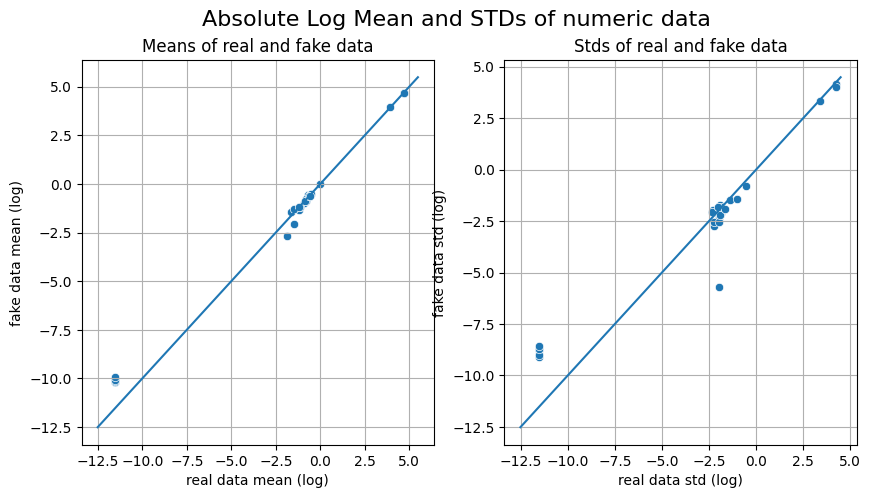

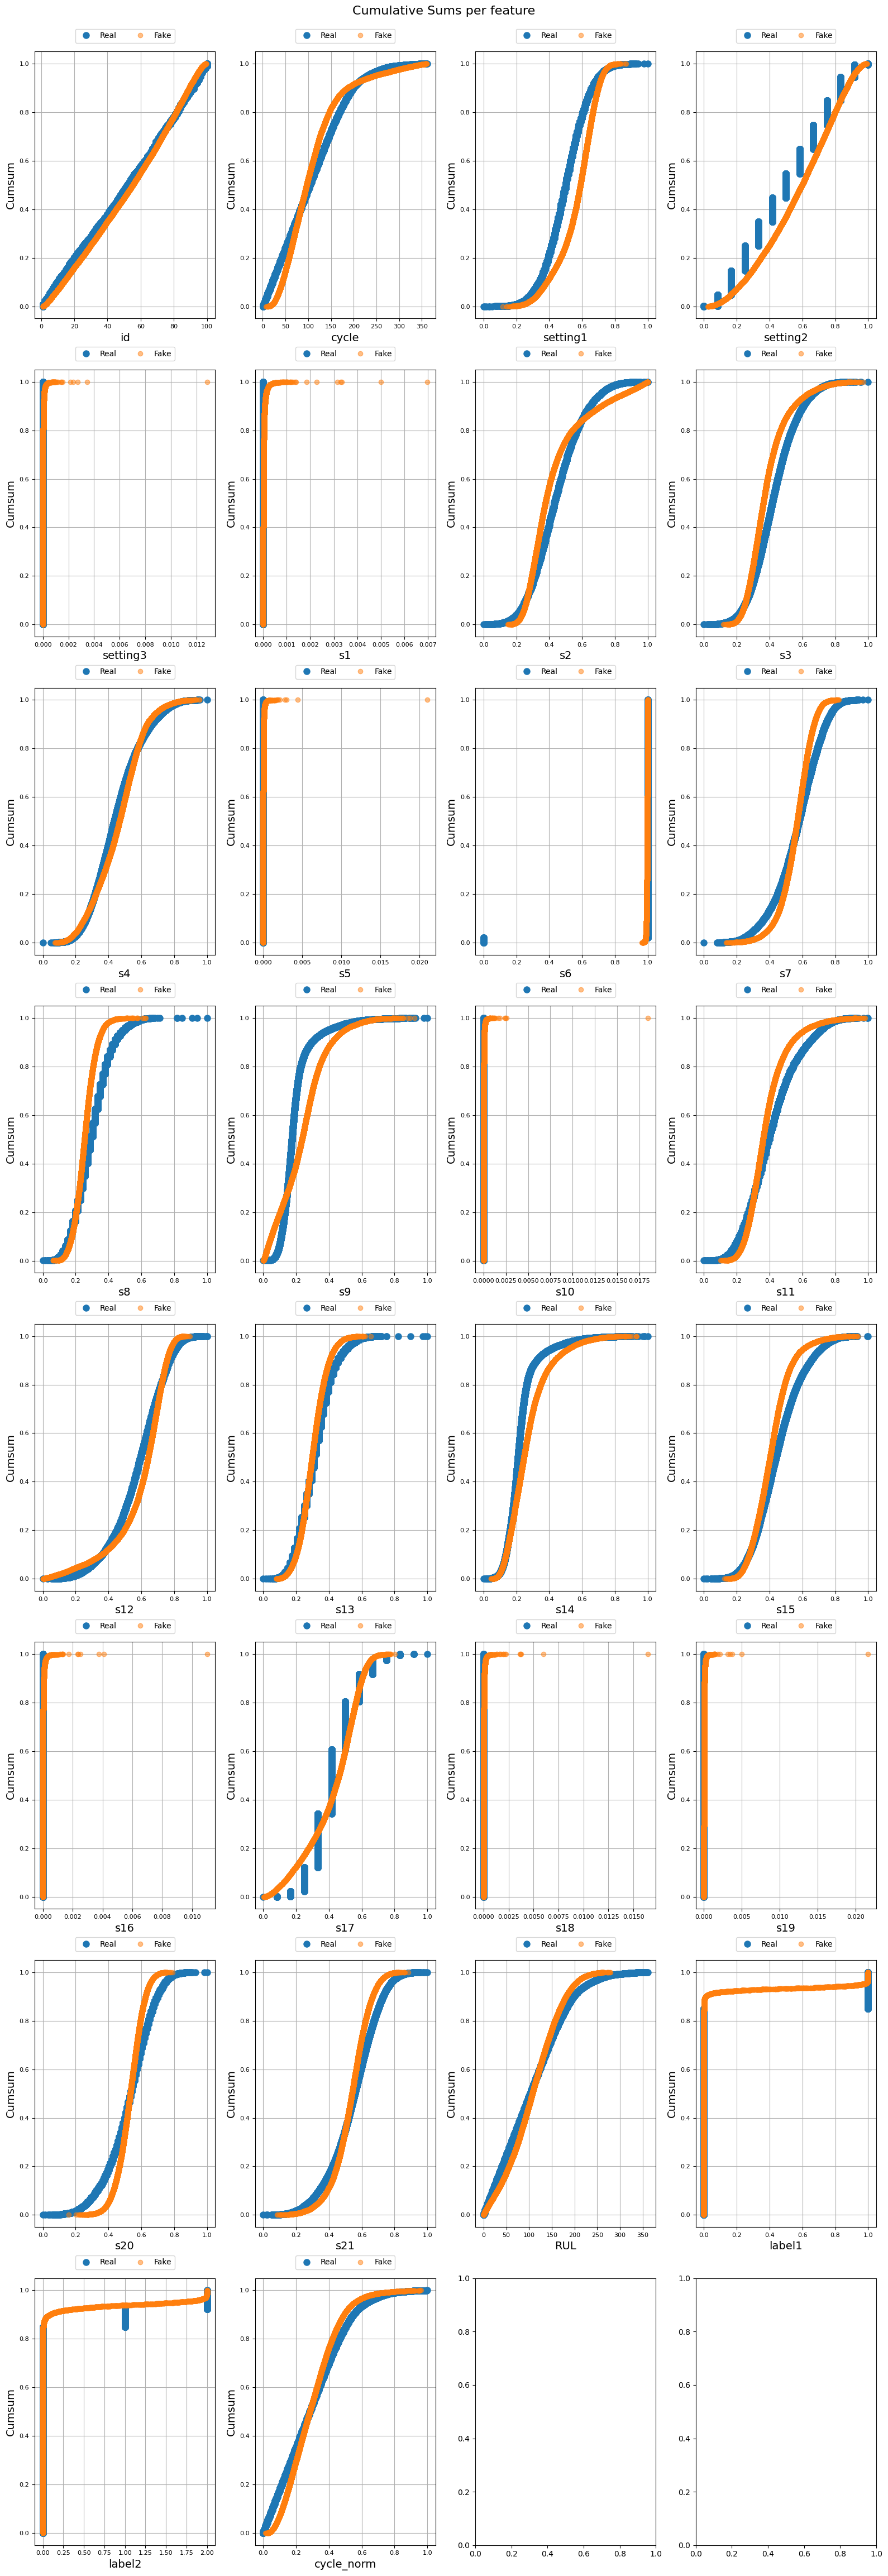

In [ ]:
from table_evaluator import TableEvaluator

print(data.shape, synthetic_data_df.shape)
table_evaluator = TableEvaluator(data, synthetic_data_df)

table_evaluator.visual_evaluation()